In [1]:
import torch
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from dataclasses import dataclass
from torch.distributions import Gamma, Multinomial

c:\Users\j1487\miniconda3\envs\EPM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
@dataclass
class ExperimentConfig:
    N: int
    K: int
    train_ratio: float
    burnin: int
    collection: int
    binary: bool

config = ExperimentConfig(100, 50, 0.8, 1500, 1500, True)

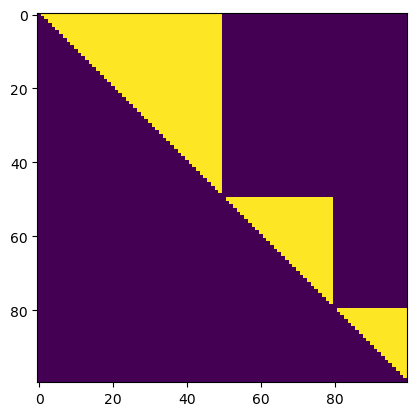

In [3]:
# Synthesize Data
syn_data = torch.zeros(config.N, config.N)
syn_data[:50, :50] = torch.ones(50, 50)
syn_data[50: 80, 50: 80] = torch.ones(30, 30)
syn_data[80:, 80:] = torch.ones(20, 20)
syn_data = torch.triu(syn_data, diagonal=1)

plt.imshow(syn_data)

In [4]:
m_idx, n_idx = torch.nonzero(syn_data, as_tuple=True)
X = syn_data[m_idx, n_idx]
AA = syn_data + syn_data.T

In [5]:
eps = 1e-32

def Po_plus(rate):
    r1 = rate[rate>=1]
    r2 = rate[rate<1]
    m = torch.zeros_like(rate)
    m1 = torch.zeros_like(r1)
    m2 = torch.zeros_like(r2)
    
    while True:
        dex = (m1 == 0).nonzero(as_tuple=True)
        if dex[0].numel() == 0:
            break
        else:
            r_dex = r1[dex]
            temp = torch.poisson(r_dex)
            idex = temp > 0
            m1[dex] = torch.where(idex, temp, m1[dex])
    m[rate>=1] = m1
    
    while True:
        dex = (m2 == 0).nonzero(as_tuple=True)
        if dex[0].numel() == 0:
            break
        else:
            r_dex = r2[dex]
            temp = 1 + torch.poisson(r_dex)
            idex = torch.rand_like(temp) < (1 / temp)
            m2[dex] = torch.where(idex, temp, m2[dex])
    m[rate<1] = m2
    
    return m

def CRT(n, a):
    max_x = torch.max(n).int().item()
    
    rate = torch.arange(max_x).expand(*a.size(), -1) + a.unsqueeze(-1)
    rate = a.unsqueeze(-1) / rate                           # size = (N, max_x)
    rate = torch.repeat_interleave(rate.unsqueeze(0), len(n), dim=0)     # size = (K, N, max_x)
    
    bers = torch.bernoulli(rate)
    range_ = torch.arange(max_x).expand(*n.size(), -1)
    mask = range_ < n.unsqueeze(-1)
    bers = bers * mask.to(torch.int)
    bers = bers.sum(dim = -1)       # size = (K, N)
    return bers

def Multrnd_histc(n, p):
    edges = torch.cumsum(p, dim=0)
    edges = torch.nn.functional.pad(edges, pad=[1, 0], value=0)
    
    r = torch.histogram(
        torch.rand(n) * edges[-1],
        edges
    ).hist
    return r

In [6]:
class GP_EPM:
    def __init__(self, config: ExperimentConfig):
        self.N = config.N
        self.K = config.K
        self.binary = config.binary

        self.gamma_0 = 1.
        self.c_0 = 1.
        self.e_0 = 1.
        self.f_0 = 0.01

        self.r = torch.ones(self.K) / self.K
        self.phi= Gamma(1., 1.).sample([self.N, self.K])
        
        self.c_i = torch.ones(self.N)
        self.a_i = torch.ones(self.N)

    def do_inference(self, X, m_idx, n_idx):
        # Sample latent interaction
        x_ij = X
        if self.binary:
            rate = (self.phi[m_idx] * self.phi[n_idx]) @ self.r  # size = (num)
            x_ij = Po_plus(rate)                                 # size = (num)
        
        x_ik = torch.zeros(self.K, self.N)
        for i, j, x in zip(m_idx, n_idx, x_ij):
            pmf = self.phi[i] * self.phi[j] * self.r
            # x_ijk = Multinomial(x.to(torch.int).item(), pmf).sample()
            x_ijk = Multrnd_histc(x.to(torch.int), pmf)
            x_ik[:, i] += x_ijk
            x_ik[:, j] += x_ijk
        print('finish x_ik')
        
        # Sample a_i
        phi_r = self.phi @ torch.diag(self.r)
        l_ik = CRT(x_ik, self.a_i).sum(dim=0)
        omega_ik = phi_r.sum(dim=0) - phi_r
        p_prime_ik = omega_ik / (self.c_i.view(-1, 1) + omega_ik)
        ai_alpha = self.e_0 + l_ik
        ai_beta = self.f_0 - torch.log(torch.clamp_min(1 - p_prime_ik, eps)).sum(dim=-1)
        self.a_i = Gamma(ai_alpha, ai_beta).sample()
        print('finish a_i')
        
        # Sample phi
        phi_alpha = self.a_i.view(-1, 1) + x_ik.T
        phi_beta = self.c_i.view(-1, 1) + omega_ik
        self.phi = Gamma(phi_alpha, phi_beta).sample()
        print('finish phi')
        
        # Sample c_i
        ci_alpha = 1 + self.K * self.a_i
        ci_beta = 1 + self.phi.sum(dim=-1)
        self.c_i = Gamma(ci_alpha, ci_beta).sample()
        print('finish c_i')
        
        # Sample r
        temp = (self.phi * (self.phi.sum(dim=0) - self.phi)).sum(dim=0) * 0.5
        r_alpha = self.gamma_0 / self.K + 0.5 * x_ij.sum(dim=-1)
        r_beta = self.c_0 + temp
        self.r = Gamma(r_alpha, r_beta).sample()
        print('finish r')
        
        # Sample gamma0
        l_tilde_k = CRT(0.5 * x_ij.sum(dim=-1, keepdim=True), torch.FloatTensor([self.gamma_0 / self.K])).sum(dim=0)
        gamma0_alpha = 1 + l_tilde_k
        gamma0_beta = 1 - 1 / self.K * torch.log(torch.clamp_min(self.c_0/(self.c_0+temp), eps)).sum()
        self.gamma_0 = Gamma(gamma0_alpha, gamma0_beta).sample()
        print('finish gamma_0')
        
        # Sample c_0
        c0_alpha = 1 + self.gamma_0
        c0_beta = 1 + self.r.sum()
        self.c_0 = Gamma(c0_alpha, c0_beta).sample()
        print('finish c_0')
        
        return x_ik

In [7]:
model = GP_EPM(config)
prob_sample = torch.zeros(config.N, config.N)
prob_ave = torch.zeros_like(prob_sample)

progress = tqdm(range(config.burnin + config.collection))
for i in progress:
    x_ik = model.do_inference(X, m_idx, n_idx).T
    
    prob = model.phi @ torch.diag(model.r) @ model.phi.T + eps
    prob = 1 - torch.exp(-prob)
    if i > config.burnin:
        prob_sample += prob
        prob_ave = prob_sample / (i - config.burnin)
    else:
        prob_ave = prob
    
    K_positive = len(x_ik.sum(dim=0).nonzero())
    
    _, rdex = torch.sort(x_ik.sum(dim=0), descending=True)
    _, z = torch.max(x_ik[:, rdex], dim=-1)
    _, rank_dex = torch.sort(z)
    
    K_hard_assignment = len(torch.unique(z))
    
    latent_feature = model.phi[rank_dex][rdex] @ (torch.diag(model.r[rdex]) ** 0.5)
    latent_feature = torch.log(latent_feature + 0.999)
    
    if (i+1)%300 == 0:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=300)
        axs[0].imshow(AA[rank_dex, rank_dex], cmap='jet')
        axs[1].imshow(prob_ave + prob_ave.T, cmap='jet')
        axs[2].imshow(latent_feature, cmap='jet')
    
    progress.set_postfix({'K+': K_positive, 'K_hard': K_hard_assignment, 'gamma0': model.gamma_0, 'max_x': torch.max(x_ik).item()})

  0%|          | 1/3000 [00:00<10:21,  4.82it/s, K+=50, K_hard=33, gamma0=tensor([0.3435]), max_x=21]

finish x_ik
finish a_i
finish phi
finish c_i
finish r
finish gamma_0
finish c_0


  0%|          | 2/3000 [00:00<10:56,  4.57it/s, K+=50, K_hard=43, gamma0=tensor([0.1825]), max_x=190]

finish x_ik
finish a_i
finish phi
finish c_i
finish r
finish gamma_0
finish c_0
finish x_ik


  0%|          | 3/3000 [00:00<18:05,  2.76it/s, K+=50, K_hard=40, gamma0=tensor([0.1072]), max_x=3947.0]

finish a_i
finish phi
finish c_i
finish r
finish gamma_0
finish c_0
finish x_ik


  0%|          | 4/3000 [00:04<1:30:14,  1.81s/it, K+=50, K_hard=35, gamma0=tensor([0.0955]), max_x=75719.0]

finish a_i
finish phi
finish c_i
finish r
finish gamma_0
finish c_0
finish x_ik
